# DNK RBC MODEL
By XXXX, YYYYY, and ZZZZ.

This paper aims to compute and forcast a Real Business Cycle Model for the Denmark economy between the years 1950 to 2023.

## Introduction
Denmark, given that being a small open economy, tends to be influenced by global economic trends, such as recessions or booms, trade agreements, and international economic conditions. \cite{pedersen2013drives} Pedersen (2013) states that over 50\% of the volatility in Denmark's real GDP can be attributed to foreign shocks. A lot of external variables contributed to the recession that Denmark experienced following the most recent financial crisis. As can be seen from the graphs of our model, the output along with consumption decreased significantly during the 2008-9 financial crisis. What is most striking is that the fall in output and consumption was as severe as during the lockdowns, due to the pandemic. In addition, the effect of the financial crisis can be well seen in the Investment and Trade Balance graphs where the deviation from the trend corresponds to the same period, namely 2008-9 and 2020.

When it comes to the graph, which depicts working hours in Denmark between the years 1988 and 2023, it can be seen that it fluctuated over time, by keeping its decreasing overall trend. Starting with the reduction in working hours in Denmark during the 1990s, \cite{burr2003trends} claims it was primarily driven by labor market and societal changes. Another important variable for the labor market, namely wages, is also presented as a part of our model. The highest wage increase was around 2008-9 by 0.020 with an all-time high. One can conclude that around 2006, the fluctuations fit in a pattern, as the graph suggests. However, the real wage growth has also seen negative parts from time to time, especially before 2008. \cite{} IMF report


Furthermore, it is beneficial to keep in mind that Denmark is a member of the European Union. Thus, changes in EU policies, expansions, or contractions of the EU, directly affect the Danish economy. In this sense, when we look at the graph of interest rates and bond yields, there is an overall decreasing trend. Taking into account that in early July 2012, Danmarks National Bank lowered its monetary-policy interest rates to historically low levels in connection with the ECB reduction of interest rates aligns with the results of our graph. One can say that the negative rate of interest on certificates of deposit was set solely with consideration to maintaining Denmark's fixed-exchange-rate policy. The fixed-exchange-rate policy entails that monetary policy is laid down to stabilize the krone against the euro. \cite{} refer to Denmark National Bank publication.

## Literature Review
Dynamic Stochastic General Equilibrium (DSGE) models have become essential tools for understanding economic fluctuations in various economies, including small open economies like Denmark. This literature review explores two key articles that contribute to the understanding of business cycles in the Danish economy through the lens of DSGE models. 

This article investigates the driving forces behind the business cycle in Denmark, employing a DSGE model tailored to the characteristics of a small open economy. The study likely delves into the specific features of the Danish economic landscape, considering factors such as trade openness, exchange rate dynamics, and international spillovers. The unique contribution of the article is identifying the main determinants of the business cycle in Denmark by discussing the role of external shocks and global economic conditions and assessing the effectiveness of monetary and fiscal policies in stabilizing the economy. 

The second article, on the other hand, extends the analysis by incorporating additional features into the DSGE model, focusing on housing, banking, and financial frictions. Such extensions are crucial for capturing the intricacies of the Danish economy, where factors like the housing market and financial sector play pivotal roles. Thus, this study diverges from the former by exploring the interactions between the banking sector and the broader economy and by assessing the implications of financial frictions on the transmission of shocks.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsdisagg import disaggregate_series
import statsmodels.api as sm

In [2]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names
from tabulate import tabulate

def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        headers = ['Specification', 'Coeff', 'Statistic', 'P-value', 'Lags', '1%', '5%', '10%']
        table = []
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            row = [f'{name}', f'{gamma:.3f}', f'{stat:.3f}', f'{p:.3f}', f'{n_lag}', f'{crit["1%"]:.3f}', f'{crit["5%"]:.3f}', f'{crit["10%"]:.3f}']
            table.append(row)

            for coef in reg_coefs.index:
                if coef in name:
                    row = [f'\t{coef}', f'{reg_coefs[coef]:.3f}', f'{reg_tstat[coef]:.3f}', f'{reg_pvals[coef]:.3f}', '', '', '', '']
                    table.append(row)

        print(tabulate(table, headers=headers, tablefmt='pretty'))
        print()  # Add an empty line between tables


                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 1950-01-01 to 2023-07-01
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Bonds       147 non-null    float64
 1   Y           115 non-null    float64
 2   C           115 non-null    float64
 3   Kformation  115 non-null    float64
 4   stock       70 non-null     float64
 5   r           755 non-null    float64
 6   Exports     115 non-null    float64
 7   Imports     115 non-null    float64
dtypes: float64(8)
memory usage: 54.0 KB


,Bonds,Y,C,Kformation,stock,r,Exports,Imports
DATE,,,,,,,,
1950-01-01,NaN,NaN,NaN,NaN,203497.859375,NaN,NaN,NaN
1951-01-01,NaN,NaN,NaN,NaN,206158.671875,NaN,NaN,NaN
1952-01-01,NaN,NaN,NaN,NaN,208901.093750,NaN,NaN,NaN
1953-01-01,NaN,NaN,NaN,NaN,214274.093750,NaN,NaN,NaN
1954-01-01,NaN,NaN,NaN,NaN,220242.234375,NaN,NaN,NaN


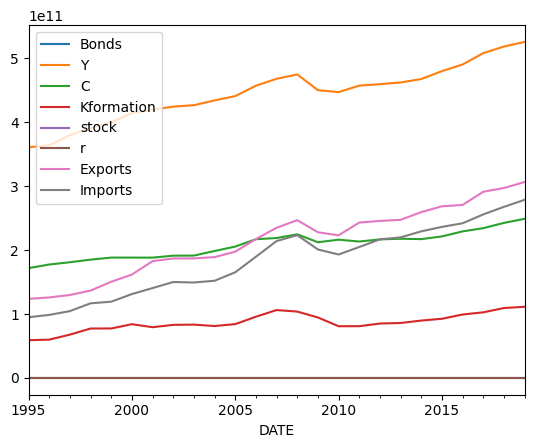

In [3]:
from pandas_datareader.fred import FredReader
fred_indicators = ['IRLTLT01DKQ156N', 'NAEXKP01DKQ189S', 'NAEXKP02DKQ189S', 'NAEXKP04DKQ189S', 'RKNANPDKA666NRUG', 'DNKLOCOSTORSTM', 'NAEXKP06DKQ652S', 'NAEXKP07DKQ652S']

df = FredReader(symbols=fred_indicators, start='1900-01-01', end=None, freq ='Q').read()

df.rename(columns={
    'IRLTLT01DKQ156N': 'Bonds', #monthly 
    'NAEXKP01DKQ189S': 'Y',
    'NAEXKP02DKQ189S': 'C',
    'NAEXKP04DKQ189S': 'Kformation',
    'RKNANPDKA666NRUG': 'stock', #annual
    'DNKLOCOSTORSTM': 'r', #monthly 
    'NAEXKP06DKQ652S': 'Exports',
    'NAEXKP07DKQ652S': 'Imports'
}, inplace=True)
df.to_csv('custom_df.csv')
df.dropna().plot()
df.info()
df.head()

In [4]:
stock = df['stock']
#setting it up in years so it stops giving me missing values error since im going from low to higher frequency with stocks 
stock = df['stock'].resample('YS').last().dropna()
stock_quarterly = disaggregate_series(stock, target_freq='QS', agg_func='last')
r = df['r'].dropna()
def compound_interest(monthly_interests):
    quarterly_interest = (1 + monthly_interests).prod() - 1
    return quarterly_interest
r_decimal = r.mul(1 / 100)
r_quarterly = r_decimal.resample('QS').agg(compound_interest)
r_quarterly = r_quarterly + 1
r_quarterly
Br = df['Bonds'].dropna()
def compound_interest(monthly_interests):
    quarterly_interest = (1 + monthly_interests).prod() - 1
    return quarterly_interest
Br_decimal = Br.mul(1 / 100)
Br_quarterly = Br_decimal.resample('QS').agg(compound_interest)
Br_quarterly = Br_quarterly + 1
Br_quarterly

DATE
1987-01-01    1.114351
1987-04-01    1.111149
1987-07-01    1.111370
1987-10-01    1.114504
1988-01-01    1.102015
                ...   
2022-07-01    1.017203
2022-10-01    1.024207
2023-01-01    1.025097
2023-04-01    1.025690
2023-07-01    1.027630
Freq: QS-JAN, Name: Bonds, Length: 147, dtype: float64

In [5]:
df1 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/ANHRS/DNK.DE+TE.A/OECD?contentType=csv')
df1.to_csv('df1.csv')
df1 = df1[df1['Employment status'] == 'Total employment']
hours = df1.loc[:,['Time','Value']]
hours = hours.rename(columns= {'Value': 'N'})
hours['Time'] = pd.to_datetime(hours['Time'], format='%Y')
hours.set_index('Time', inplace=True)
quarterly_N = disaggregate_series(hours, target_freq='QS', agg_func='sum')
quarterly_N

1970-01-01    462.788670
1970-04-01    462.208044
1970-07-01    461.046792
1970-10-01    459.304914
1971-01-01    456.982409
                 ...    
2021-10-01    342.374966
2022-01-01    342.655797
2022-04-01    342.866420
2022-07-01    343.006836
2022-10-01    343.077043
Freq: QS-OCT, Name: N, Length: 212, dtype: float64

In [6]:
df1.dropna(inplace=True) 
print("Remaining missing values:", df1.isnull().sum().sum())

Remaining missing values: 0


In [7]:
df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
df2.to_csv('df2.csv')
df2 = df2[df2['Subject'] == 'Manufacturing, Index']
wages = df2.loc[:,['Time','Value']]
wages = wages.rename(columns= {'Value': 'w'})
wages['Time'] = wages['Time'].apply(lambda x: x[3:] + "-" + "Q" + x[1])
wages['Time'] = pd.to_datetime(wages['Time'])
wages.set_index('Time', inplace=True)
wages.head()

/tmp/ipykernel_10457/2957788866.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
/tmp/ipykernel_10457/2957788866.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = pd.read_csv('https://stats.oecd.org/SDMX-JSON/data/EAR_MEI/LCEAMN01_IXOB+LCEAMN01_IXOBSA+LCEAPR_IXOBSA.DNK.Q/OECD?contentType=csv', parse_dates=['Time'], infer_datetime_format=True)
/tmp/ipykernel_10457/2957788866.py:7: UserWarning: Could not infer format, so each element will

,w
Time,
1971-01-01,6.801153
1971-04-01,7.283459
1971-07-01,7.472557
1971-10-01,7.702024
1972-01-01,7.810383


In [8]:
df_quarterly = pd.DataFrame()

In [9]:
df_quarterly['Br_quarterly'] = Br_quarterly
df_quarterly['r_quarterly'] = r_quarterly
df_quarterly['stock_quarterly'] = stock_quarterly
C = df['C']
df_quarterly['C_quarterly'] = C
Y = df['Y']
df_quarterly['Y_quarterly'] = Y
K = df['Kformation']
df_quarterly['K_quarterly'] = K
EX = df['Exports']
df_quarterly['EX_quarterly'] = EX
IM = df['Imports']
df_quarterly['IM_quarterly'] = IM
df_quarterly

,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly
DATE,,,,,,,,
1987-01-01,1.114351,1.225043,799708.218750,NaN,NaN,NaN,NaN,NaN
1987-04-01,1.111149,1.225043,806198.625000,NaN,NaN,NaN,NaN,NaN
1987-07-01,1.111370,1.225043,812689.031250,NaN,NaN,NaN,NaN,NaN
1987-10-01,1.114504,1.225043,819179.437500,NaN,NaN,NaN,NaN,NaN
1988-01-01,1.102015,1.225043,824458.390625,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07-01,1.017203,1.006500,NaN,2.535687e+11,5.704050e+11,1.220930e+11,3.617697e+11,3.143486e+11
2022-10-01,1.024207,1.025156,NaN,2.528550e+11,5.719180e+11,1.385479e+11,3.607410e+11,3.201785e+11
2023-01-01,1.025097,NaN,NaN,2.534612e+11,5.779868e+11,1.187667e+11,3.741787e+11,3.156046e+11


In [10]:
merged = df_quarterly.join([quarterly_N, wages])
merged

,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly,N,w
DATE,,,,,,,,,,
1987-01-01,1.114351,1.225043,799708.218750,NaN,NaN,NaN,NaN,NaN,376.969796,36.85957
1987-04-01,1.111149,1.225043,806198.625000,NaN,NaN,NaN,NaN,NaN,374.055140,38.62382
1987-07-01,1.111370,1.225043,812689.031250,NaN,NaN,NaN,NaN,NaN,371.798882,38.72432
1987-10-01,1.114504,1.225043,819179.437500,NaN,NaN,NaN,NaN,NaN,370.201021,39.53945
1988-01-01,1.102015,1.225043,824458.390625,NaN,NaN,NaN,NaN,NaN,369.261557,39.55061
...,...,...,...,...,...,...,...,...,...,...
2022-07-01,1.017203,1.006500,NaN,2.535687e+11,5.704050e+11,1.220930e+11,3.617697e+11,3.143486e+11,343.006836,117.93010
2022-10-01,1.024207,1.025156,NaN,2.528550e+11,5.719180e+11,1.385479e+11,3.607410e+11,3.201785e+11,343.077043,118.15920
2023-01-01,1.025097,NaN,NaN,2.534612e+11,5.779868e+11,1.187667e+11,3.741787e+11,3.156046e+11,NaN,118.84670


In [11]:
merged.dropna(inplace=True) 
print("Remaining missing values:", merged.isnull().sum().sum())
merged.head()

Remaining missing values: 0


,Br_quarterly,r_quarterly,stock_quarterly,C_quarterly,Y_quarterly,K_quarterly,EX_quarterly,IM_quarterly,N,w
DATE,,,,,,,,,,
1995-01-01,1.089600,1.168650,939142.859375,1.717697e+11,3.608200e+11,5.903179e+10,1.237207e+11,9.494988e+10,353.569687,52.22259
1995-04-01,1.084437,1.191016,943527.093750,1.737711e+11,3.597877e+11,5.976629e+10,1.213563e+11,9.632093e+10,355.063215,52.76544
1995-07-01,1.080877,1.165894,947911.328125,1.746535e+11,3.612882e+11,6.266278e+10,1.207843e+11,9.678716e+10,355.532891,53.25401
1995-10-01,1.075830,1.146620,952295.562500,1.750917e+11,3.639317e+11,6.607297e+10,1.221478e+11,9.977737e+10,354.978715,53.74258
1996-01-01,1.073490,1.122160,957127.187500,1.774266e+11,3.639864e+11,5.985612e+10,1.259050e+11,9.859263e+10,353.400688,54.28543


Br_quarterly


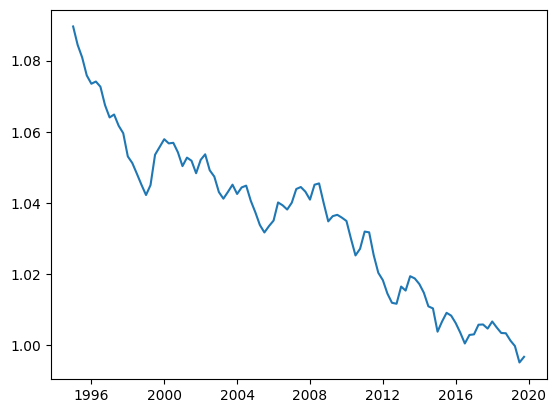

r_quarterly


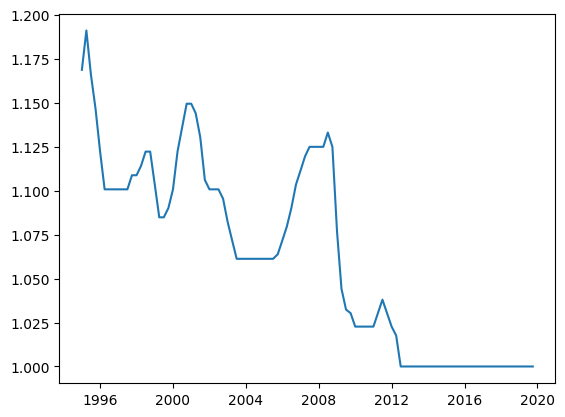

stock_quarterly


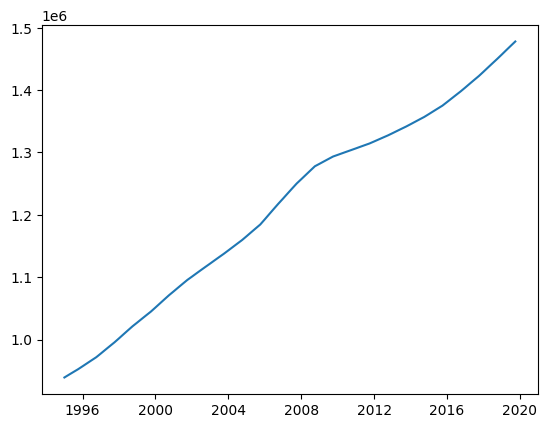

C_quarterly


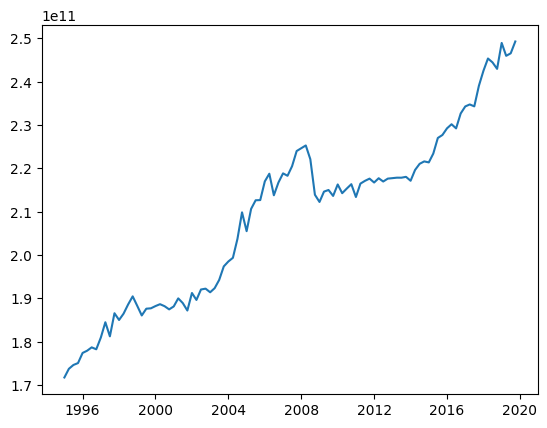

Y_quarterly


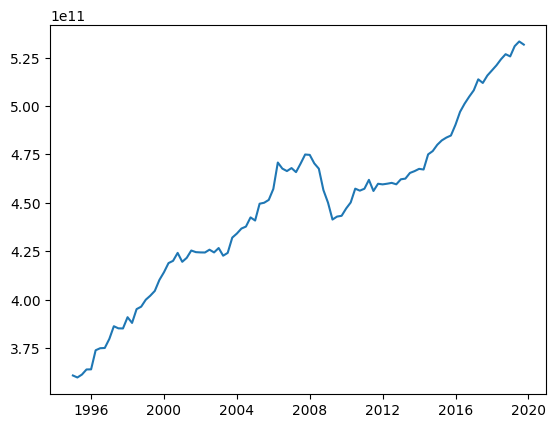

K_quarterly


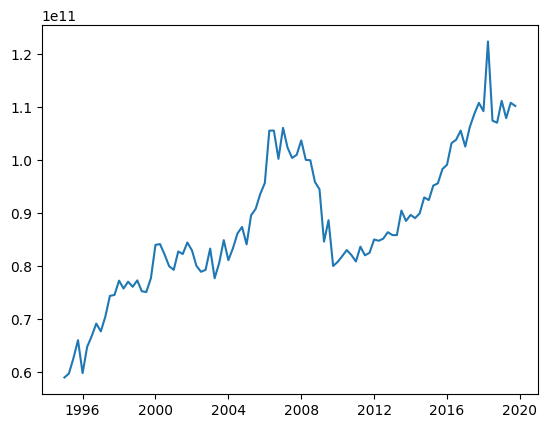

EX_quarterly


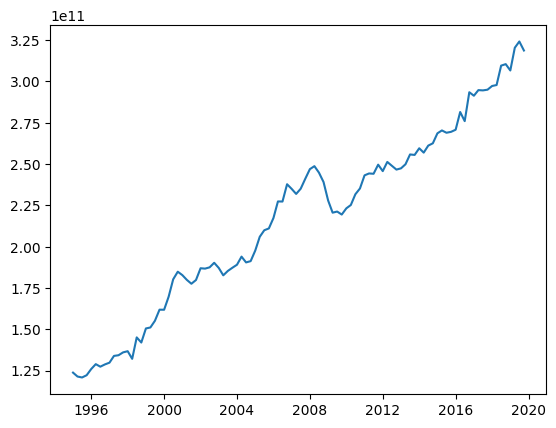

IM_quarterly


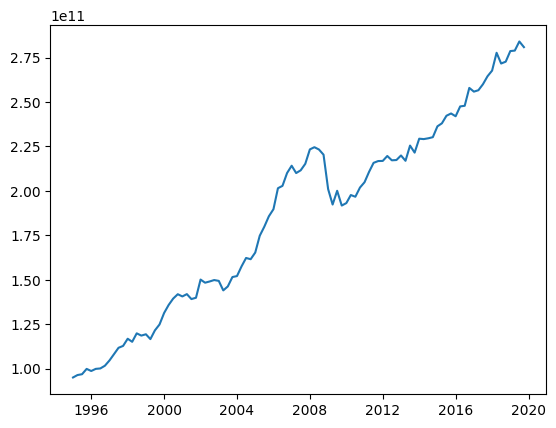

N


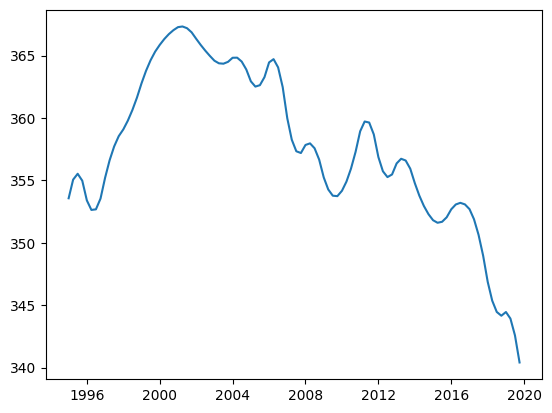

w


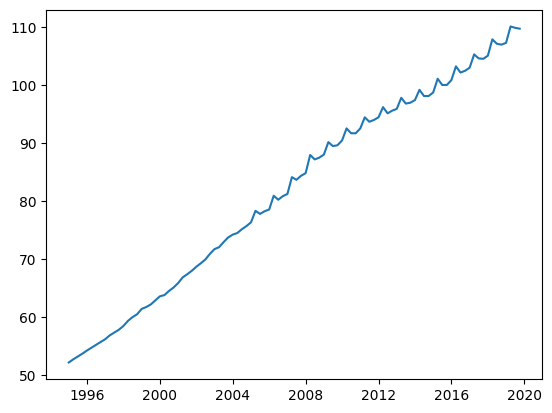

In [12]:
for columns in merged.columns:
    print(columns)
    column_data = merged[columns].dropna()
    plt.plot(column_data, label=columns)
    plt.show()

<Axes: xlabel='DATE', ylabel='Resid'>

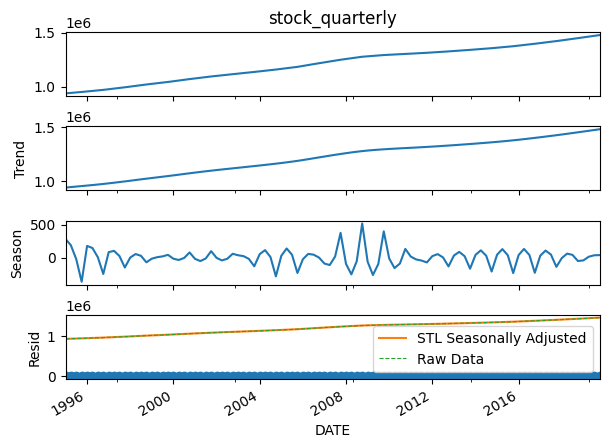

In [13]:
#Let's start with stock, aka investment 
stl_res= sm.tsa.STL(merged.stock_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['stock_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['stock_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

<Axes: xlabel='DATE', ylabel='Resid'>

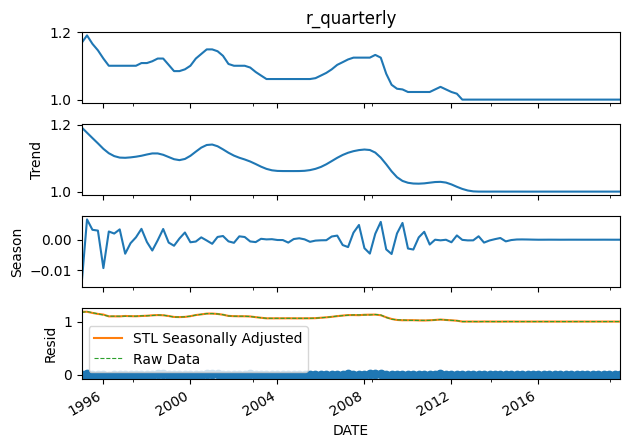

In [14]:
#now for r
stl_res= sm.tsa.STL(merged.r_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['r_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['r_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

<Axes: xlabel='DATE', ylabel='Resid'>

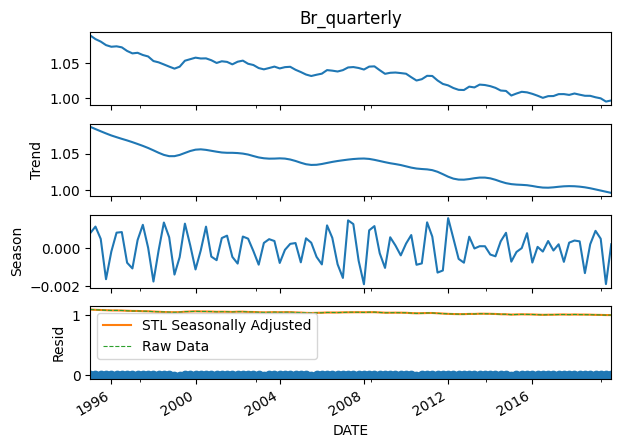

In [15]:
#finally, for bonds 
stl_res= sm.tsa.STL(merged.Br_quarterly.dropna(), period=4).fit()
stl_res.plot()
#actual detrending 
(merged['Br_quarterly'].dropna() - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
merged['Br_quarterly'].dropna().plot(ls='--', lw=0.8, label='Raw Data', legend=True)

In [16]:
#seasonal adjustment is done 
#moving on to de-trending 
#Let's start with everything but the rates 

<Axes: xlabel='DATE'>

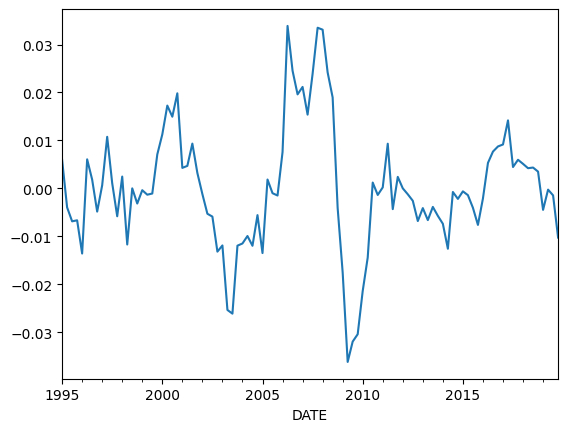

In [17]:
#starting with Y 
LogY = np.log(merged['Y_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogY)
LogY = cycle
LogY.plot()

<Axes: xlabel='DATE'>

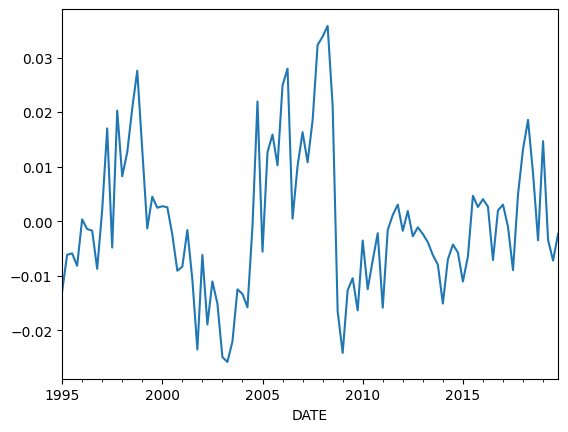

In [18]:
#now C  
LogC = np.log(merged['C_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogC)
C = LogC = cycle
C.plot()

<Axes: xlabel='DATE'>

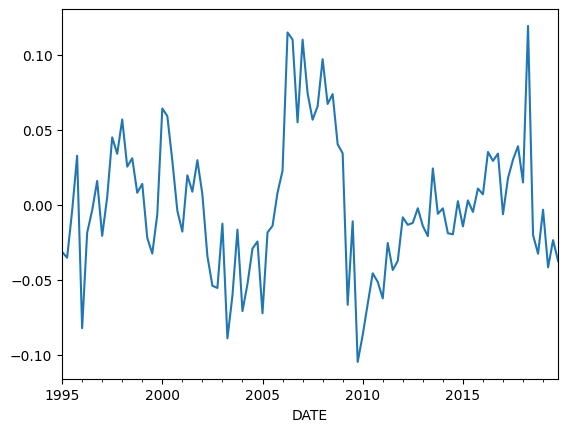

In [19]:
#now K
LogK = np.log(merged['K_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogK)
K = LogK = cycle
K.plot()

In [20]:
#de-trending rates:
merged['r_quarterly'] = merged['r_quarterly'] - merged['r_quarterly'].mean()
merged['Br_quarterly'] = merged['Br_quarterly'] - merged['Br_quarterly'].mean()

<Axes: xlabel='DATE'>

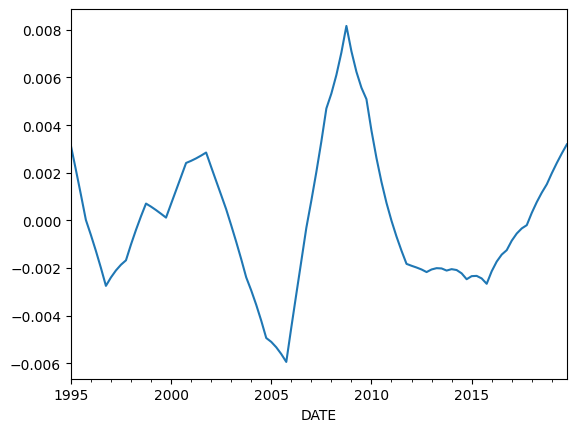

In [21]:
merged['stock_quarterly'] = merged['stock_quarterly'].dropna()
LogI= np.log(merged['stock_quarterly'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogI)
I = LogI = cycle
I.plot()

<Axes: xlabel='DATE'>

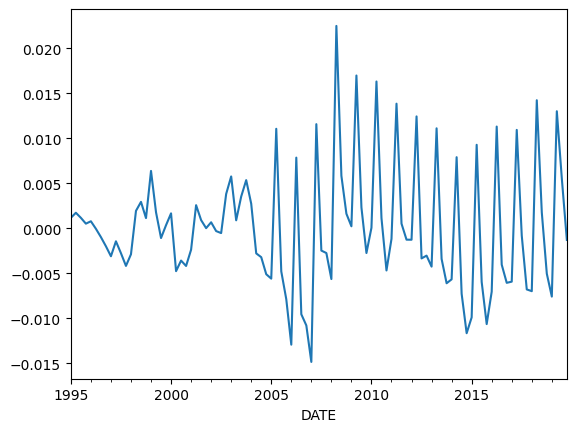

In [22]:
Logw= np.log(merged['w'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(Logw)
w = Logw = cycle
w.plot()

<Axes: xlabel='DATE'>

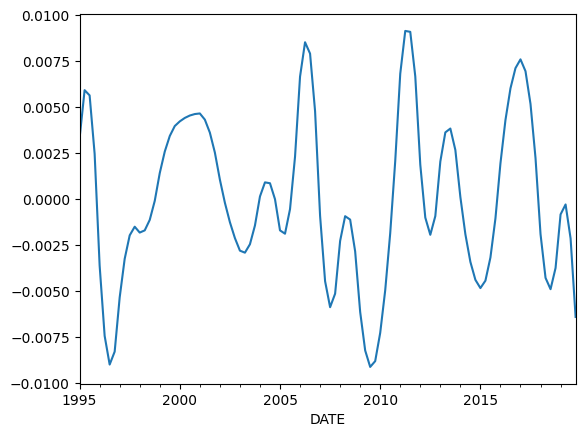

In [23]:
LogN= np.log(merged['N'].dropna())
cycle, trend = sm.tsa.hp_filter.hpfilter(LogN)
N = LogN = cycle
N.plot()

In [24]:
#now make the trade balance variables 
TB = EX - IM
TB_to_Y = TB / Y
merged ['TB_to_Y'] = TB_to_Y

In [25]:
processed = pd.DataFrame()
processed['Y'] = LogY
processed['C'] = C
processed['I'] = I
processed['K'] = K
processed['TB_to_Y'] = merged['TB_to_Y']
processed['N'] = N
processed['r'] = merged['r_quarterly']
processed['w'] = w
processed['R'] = merged['Br_quarterly']
processed

,Y,C,I,K,TB_to_Y,N,r,w,R
DATE,,,,,,,,,
1995-01-01,0.005956,-0.012950,0.003148,-0.031336,0.079737,0.003314,0.105556,0.001157,0.054716
1995-04-01,-0.003977,-0.006173,0.002130,-0.035218,0.069584,0.005925,0.127922,0.001721,0.049553
1995-07-01,-0.006886,-0.005908,0.001089,-0.004120,0.066421,0.005641,0.102800,0.001159,0.045993
1995-10-01,-0.006673,-0.008181,0.000021,0.032705,0.061469,0.002468,0.083525,0.000511,0.040946
1996-01-01,-0.013601,0.000323,-0.000609,-0.082173,0.075037,-0.003618,0.059066,0.000776,0.038606
...,...,...,...,...,...,...,...,...,...
2018-10-01,0.003486,-0.003515,0.001517,-0.032540,0.071514,-0.003751,-0.063094,-0.005044,-0.031591
2019-01-01,-0.004496,0.014666,0.001982,-0.003216,0.053014,-0.000835,-0.063094,-0.007589,-0.033651
2019-04-01,-0.000271,-0.003463,0.002412,-0.041605,0.077872,-0.000293,-0.063094,0.012997,-0.035187


(90, 9)
(90, 9)
Y


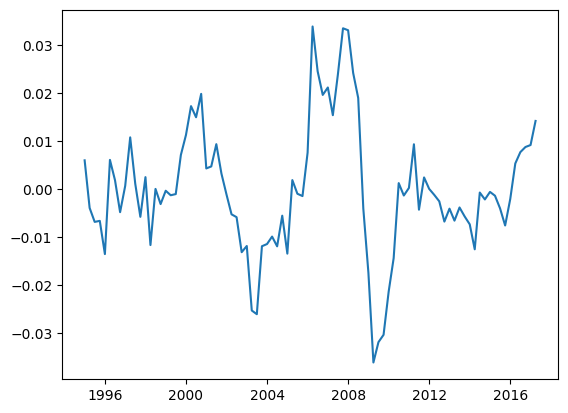

C


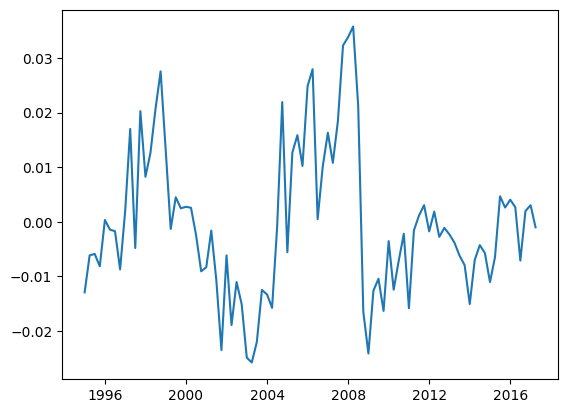

I


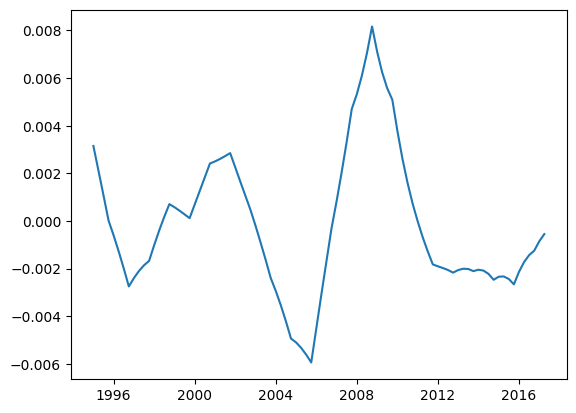

K


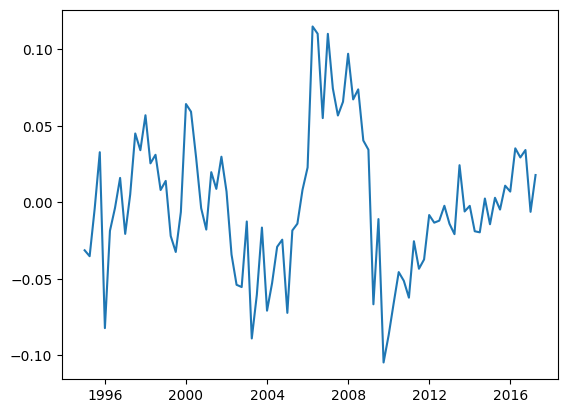

TB_to_Y


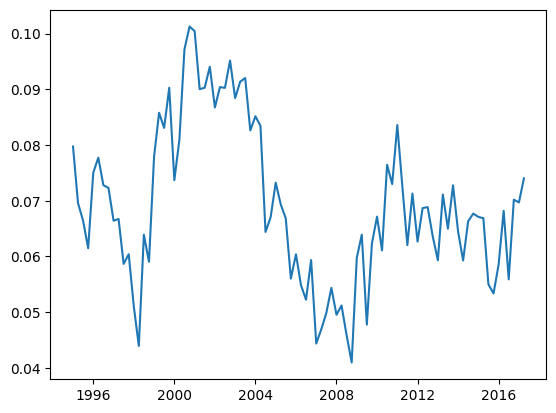

N


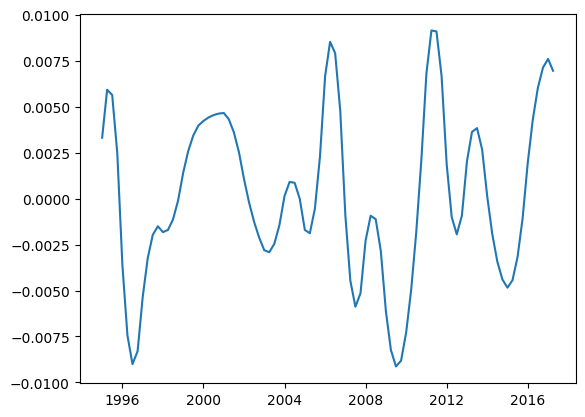

r


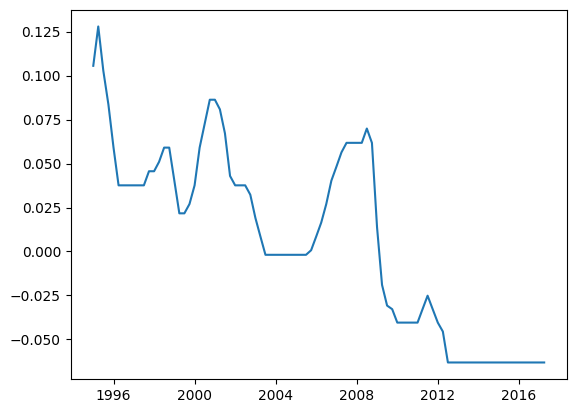

w


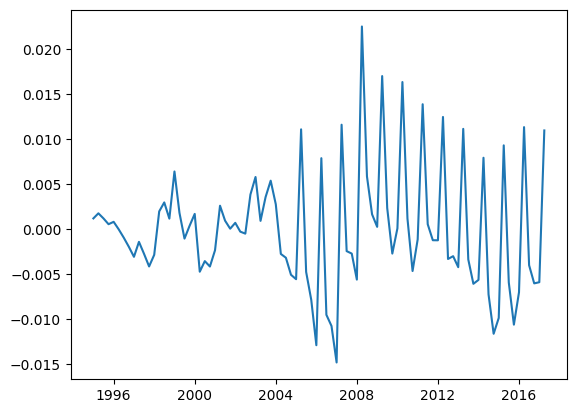

R


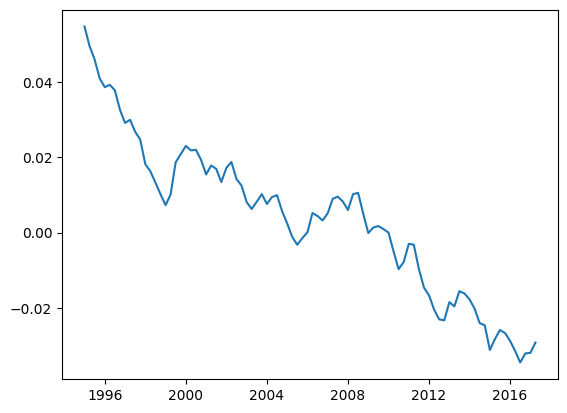

In [26]:
#train/split
n_test=10
processed_train = processed.iloc[:-n_test, :].copy()
processed_test= processed.iloc[:-n_test, :].copy()
print(processed_train.shape)
print(processed_test.shape)
for columns in processed_train.columns:
    print(columns)
    columntrain_data = processed_train[columns].dropna()
    plt.plot(columntrain_data, label=columns)
    plt.show()

In [27]:
ADF_test_summary(processed_train, missing = 'drop') 

                                                      Y                                                       
+--------------------+--------+-----------+---------+------+--------+--------+--------+
|   Specification    | Coeff  | Statistic | P-value | Lags |   1%   |   5%   |  10%   |
+--------------------+--------+-----------+---------+------+--------+--------+--------+
| Constant and Trend | -0.178 |  -2.850   |  0.179  |  0   | -4.064 | -3.461 | -3.157 |
|      Constant      | -0.001 |  -0.303   |  0.762  |      |        |        |        |
|       Trend        | 0.000  |   0.378   |  0.707  |      |        |        |        |
|   Constant Only    | -0.179 |  -2.879   |  0.048  |  0   | -3.506 | -2.895 | -2.584 |
|      Constant      | 0.000  |   0.050   |  0.960  |      |        |        |        |
|    No Constant     | -0.179 |  -2.897   |  0.004  |  0   | -2.591 | -1.944 | -1.614 |
+--------------------+--------+-----------+---------+------+--------+--------+--------+

        

Y


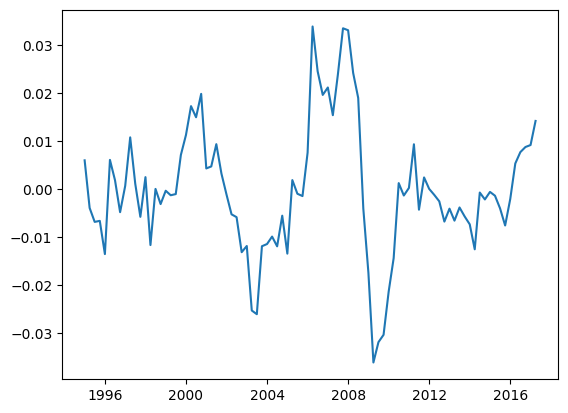

DATE
1995-01-01    0.005956
1995-04-01   -0.003977
1995-07-01   -0.006886
1995-10-01   -0.006673
1996-01-01   -0.013601
                ...   
2016-04-01    0.005303
2016-07-01    0.007668
2016-10-01    0.008737
2017-01-01    0.009148
2017-04-01    0.014174
Freq: QS-JAN, Name: Y, Length: 90, dtype: float64

C


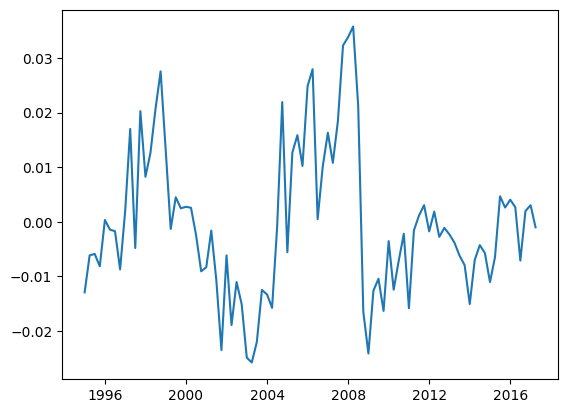

DATE
1995-01-01   -0.012950
1995-04-01   -0.006173
1995-07-01   -0.005908
1995-10-01   -0.008181
1996-01-01    0.000323
                ...   
2016-04-01    0.002660
2016-07-01   -0.007127
2016-10-01    0.001955
2017-01-01    0.003029
2017-04-01   -0.001026
Freq: QS-JAN, Name: C, Length: 90, dtype: float64

I


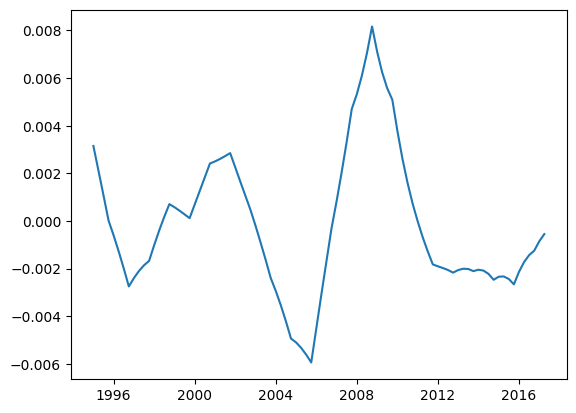

DATE
1995-01-01    0.003148
1995-04-01    0.002130
1995-07-01    0.001089
1995-10-01    0.000021
1996-01-01   -0.000609
                ...   
2016-04-01   -0.001726
2016-07-01   -0.001433
2016-10-01   -0.001247
2017-01-01   -0.000850
2017-04-01   -0.000549
Freq: QS-JAN, Name: I, Length: 90, dtype: float64

K


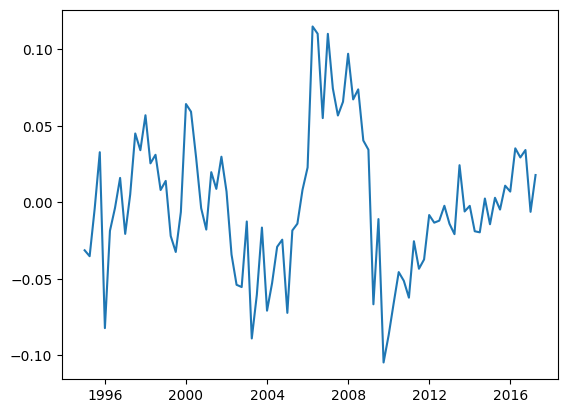

DATE
1995-01-01   -0.031336
1995-04-01   -0.035218
1995-07-01   -0.004120
1995-10-01    0.032705
1996-01-01   -0.082173
                ...   
2016-04-01    0.035239
2016-07-01    0.029282
2016-10-01    0.034133
2017-01-01   -0.006233
2017-04-01    0.017812
Freq: QS-JAN, Name: K, Length: 90, dtype: float64

TB_to_Y


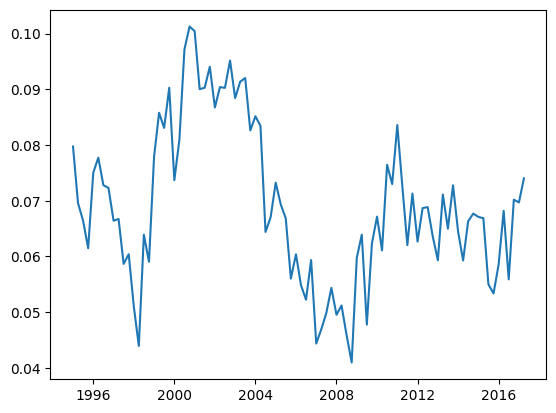

DATE
1995-01-01    0.079737
1995-04-01    0.069584
1995-07-01    0.066421
1995-10-01    0.061469
1996-01-01    0.075037
                ...   
2016-04-01    0.068188
2016-07-01    0.055880
2016-10-01    0.070185
2017-01-01    0.069699
2017-04-01    0.074019
Freq: QS-JAN, Name: TB_to_Y, Length: 90, dtype: float64

N


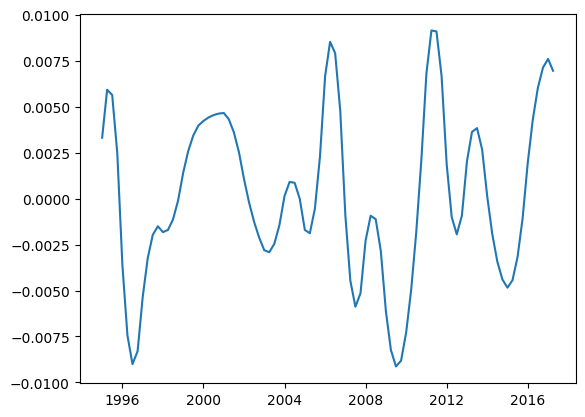

DATE
1995-01-01    0.003314
1995-04-01    0.005925
1995-07-01    0.005641
1995-10-01    0.002468
1996-01-01   -0.003618
                ...   
2016-04-01    0.004300
2016-07-01    0.006024
2016-10-01    0.007124
2017-01-01    0.007602
2017-04-01    0.006957
Freq: QS-JAN, Name: N, Length: 90, dtype: float64

r


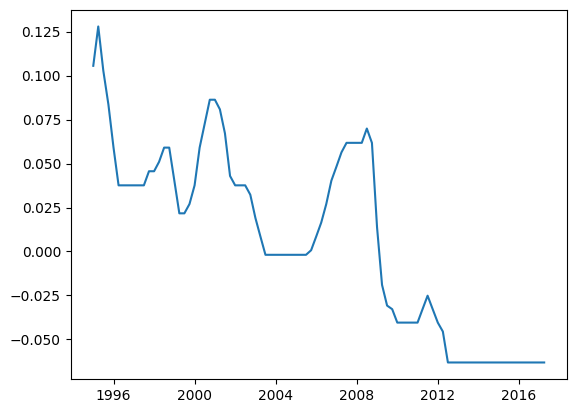

DATE
1995-01-01    0.105556
1995-04-01    0.127922
1995-07-01    0.102800
1995-10-01    0.083525
1996-01-01    0.059066
                ...   
2016-04-01   -0.063094
2016-07-01   -0.063094
2016-10-01   -0.063094
2017-01-01   -0.063094
2017-04-01   -0.063094
Freq: QS-JAN, Name: r, Length: 90, dtype: float64

w


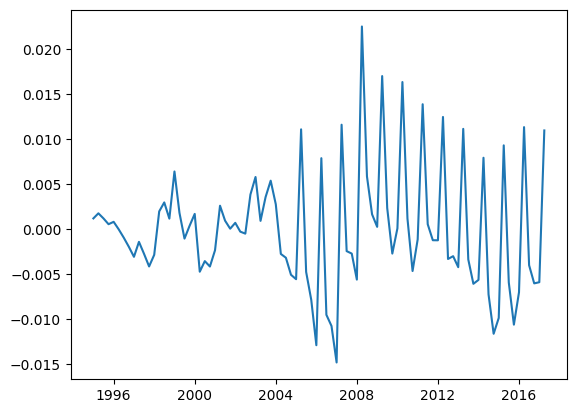

DATE
1995-01-01    0.001157
1995-04-01    0.001721
1995-07-01    0.001159
1995-10-01    0.000511
1996-01-01    0.000776
                ...   
2016-04-01    0.011294
2016-07-01   -0.004042
2016-10-01   -0.006060
2017-01-01   -0.005931
2017-04-01    0.010924
Freq: QS-JAN, Name: w, Length: 90, dtype: float64

R


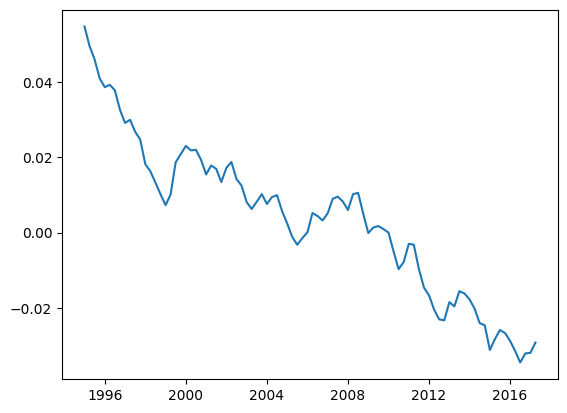

DATE
1995-01-01    0.054716
1995-04-01    0.049553
1995-07-01    0.045993
1995-10-01    0.040946
1996-01-01    0.038606
                ...   
2016-04-01   -0.031434
2016-07-01   -0.034467
2016-10-01   -0.032067
2017-01-01   -0.031897
2017-04-01   -0.029187
Freq: QS-JAN, Name: R, Length: 90, dtype: float64

In [28]:
from IPython.display import display
for columns in processed_train.columns:
    print(columns)
    columntrain_data = processed_train[columns].dropna()
    plt.plot(columntrain_data, label=columns)
    plt.show()

    # Use display function to show the data
    display(processed_train[columns])

In [29]:
# Define macroeconomic model
def macroeconomic_model(params, data):
    # Replace the following line with actual model equations
    model_output = params[0] * data['C'] + params[1] * data['I']
    
    return model_output

# Calibration: Initial values for parameters
initial_params = [0.5, 0.5]  # Replace with initial values

# Steady-state computation
def compute_steady_state(params, data):
    # Replace the following line with actual steady-state computation
    steady_state = params[0] * data['C'].mean() + params[1] * data['I'].mean()
    
    return steady_state

# Perturbation solution
def perturbation_solution(params, data, steady_state):
    # Replace the following line with actual perturbation solution
    perturbation_output = params[0] * data['C'] + params[1] * data['I'] - steady_state
    
    return perturbation_output

# Blanchard-Khan conditions check
def check_bk_conditions(params, data, steady_state):
    """
    Check the Blanchard-Khan conditions.

    Args:
    params (list): List of parameters for the model.
    data (DataFrame): DataFrame containing the relevant macroeconomic data.
    steady_state (DataFrame): DataFrame containing the steady-state values.

    Returns:
    eigenvalues (array): Eigenvalues of the matrix A.
    bk_conditions_satisfied (bool): True if Blanchard-Khan conditions are satisfied, False otherwise.
    """
    # Assuming 'Y', 'C', and 'I' are the variables of interest
    A = np.array([[params[0], params[1]], [params[1], params[0]]])  # Corrected indexing
    
    # Eigenvalues of the matrix A
    eigenvalues = np.linalg.eigvals(A)

    # Check if all eigenvalues are within the unit circle
    bk_conditions_satisfied = all(np.abs(eig) < 1 for eig in eigenvalues)

    return eigenvalues, bk_conditions_satisfied

# Calculate steady state and perturbation solution
initial_calibration_results = macroeconomic_model(initial_params, processed_train)

# Display eigenvalue table or plot for Blanchard-Khan conditions
eigenvalues, bk_conditions_satisfied = check_bk_conditions(initial_params, processed_train, initial_calibration_results)
print("Eigenvalues:", eigenvalues)
print("Blanchard-Khan Conditions Satisfied:", bk_conditions_satisfied)

# Regression estimation
def estimate_model(params, data):
    """
    Estimate a regression model.

    Args:
    params (list): List of parameters for the regression model.
    data (DataFrame): DataFrame containing the relevant macroeconomic data.

    Returns:
    regression_results: Results of the regression model.
    """
    X = sm.add_constant(data[['C', 'I']])
    y = data['Y']

    # Replace the following line with actual regression estimation
    regression_results = sm.OLS(y, X).fit()

    return regression_results

# Comparison of estimated parameters with initial calibration
estimated_params = estimate_model(initial_params, processed_train)

# Save the model to a GCN file
with open('my_model.cgn', 'w') as file:
    file.write("# Macro Model Equations\n")
    file.write("Y = const + beta1 * C + beta2 * I\n\n")
    file.write("# Calibration Parameters\n")
    file.write(f"const = {estimated_params.params['const']}\n")
    file.write(f"beta1 = {estimated_params.params['C']}\n")
    file.write(f"beta2 = {estimated_params.params['I']}\n")

# Post-estimation discussion
# Recompute steady-state and perturbation solution using fitted values
fitted_values = estimated_params.fittedvalues
updated_steady_state = compute_steady_state(estimated_params.params, processed_train)
updated_perturbation_solution = perturbation_solution(estimated_params.params, processed_train, updated_steady_state)

# Display results, perform analysis, etc.
print("Initial Calibration Results:")
print(initial_calibration_results)

Eigenvalues: [1.00000000e+00 1.11022302e-16]
Blanchard-Khan Conditions Satisfied: False
Initial Calibration Results:
DATE
1995-01-01   -0.004901
1995-04-01   -0.002022
1995-07-01   -0.002409
1995-10-01   -0.004080
1996-01-01   -0.000143
                ...   
2016-04-01    0.000467
2016-07-01   -0.004280
2016-10-01    0.000354
2017-01-01    0.001089
2017-04-01   -0.000787
Freq: QS-JAN, Length: 90, dtype: float64


/tmp/ipykernel_10457/3662903314.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steady_state = params[0] * data['C'].mean() + params[1] * data['I'].mean()
/tmp/ipykernel_10457/3662903314.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  perturbation_output = params[0] * data['C'] + params[1] * data['I'] - steady_state


In [30]:
print("Estimated Parameters:")
print(estimated_params.params)

Estimated Parameters:
const    0.000194
C        0.612525
I        0.533632
dtype: float64


In [31]:
print("Updated Steady State:")
print(updated_steady_state)

Updated Steady State:
-9.291274017786885e-05


In [32]:
print("Updated Perturbation Solution:")
print(updated_perturbation_solution)

Updated Perturbation Solution:
DATE
1995-01-01    0.002018
1995-04-01    0.001396
1995-07-01    0.000759
1995-10-01    0.000104
1996-01-01   -0.000280
                ...   
2016-04-01   -0.000964
2016-07-01   -0.000786
2016-10-01   -0.000671
2017-01-01   -0.000427
2017-04-01   -0.000243
Freq: QS-JAN, Length: 90, dtype: float64


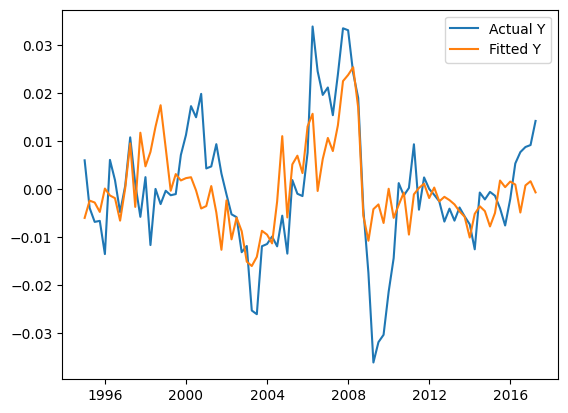

In [33]:
# Plot the results for visual inspection
plt.plot(processed_train.index, processed_train['Y'], label='Actual Y')
plt.plot(processed_train.index, fitted_values, label='Fitted Y')
plt.legend()
plt.show()